# Meeting 03.05.2024 Christoph-Nils-Arne
Varianz vorhersagen ist der Kern

einfaches Regressionsmodell 

GARCH
Nils LSTM

Kaggle aufsetzen 
Copilot

### Packages:
- AEON 
- SK Time 
- DARts 

optimal stopping 

LIteratur:
- https://rdcu.be/dGI38

In [1]:
# pip install openpyxl

In [2]:
# pip install arch

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf

# Nils - Arne 16.05.24
- extract USD - EURO pair from the dataset
- LinearRegression (ARne)
- GARCH(Nils)



In [6]:

file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'
data = pd.read_excel(file_path)



<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\arnet\AppData\Local\Temp\ipykernel_40272\4088575790.py:1: SyntaxWarning: invalid escape sequence '\B'
  file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'


In [7]:
start_index = 3
EURUSD = data.iloc[start_index:, :2]

# Rename the columns
EURUSD.columns = ['Dates', 'Close']

# Display the first few rows of the new dataset to verify
print(EURUSD.head())

                 Dates   Close
3  2023-10-03 23:00:00  1.0469
4  2023-10-03 23:15:00  1.0466
5  2023-10-03 23:30:00  1.0465
6  2023-10-03 23:45:00  1.0465
7  2023-10-04 00:00:00  1.0468


In [8]:
# Convert the 'Dates' column to datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])

# Calculate the difference between consecutive dates
EURUSD['TimeDiff'] = EURUSD['Dates'].diff()

# Define the 15-minute time interval
time_interval = pd.Timedelta(minutes=15)

# Identify the sections with consecutive 15-minute intervals
EURUSD['IsConsecutive'] = EURUSD['TimeDiff'] == time_interval

# Add a column to identify the observation blocks
EURUSD['Block'] = (EURUSD['IsConsecutive'] != EURUSD['IsConsecutive'].shift()).cumsum()

# Filter out sections with fewer than 2 days of consecutive 15-minute observations
min_consecutive_minutes = 2 * 24 * 60  # 2 days in minutes
valid_blocks = EURUSD.groupby('Block').filter(lambda x: len(x) >= min_consecutive_minutes / 15).Block.unique()
EURUSD_filtered = EURUSD[EURUSD['Block'].isin(valid_blocks)]

# Add the observation timeframe column
EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1

# Drop the 'TimeDiff' and 'IsConsecutive' columns as they are no longer needed
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeDiff', 'IsConsecutive'])

# Display the first few rows of the filtered dataset with the new 'Block' and 'TimeFrame' columns
print(EURUSD_filtered.head())

                Dates   Close  Block  TimeFrame
4 2023-10-03 23:15:00  1.0466      2          1
5 2023-10-03 23:30:00  1.0465      2          2
6 2023-10-03 23:45:00  1.0465      2          3
7 2023-10-04 00:00:00  1.0468      2          4
8 2023-10-04 00:15:00  1.0467      2          5


C:\Users\arnet\AppData\Local\Temp\ipykernel_40272\3678701610.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1


In [9]:
# Create a mapping from original block numbers to sequential block numbers
block_mapping = {old_block: new_block for new_block, old_block in enumerate(EURUSD_filtered['Block'].unique(), 1)}


In [10]:
# Apply the mapping to the Block column
EURUSD_filtered['Block'] = EURUSD_filtered['Block'].map(block_mapping)


In [11]:
EURUSD_filtered = EURUSD_filtered.reset_index(drop=True)
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeFrame'])



In [12]:
print(EURUSD_filtered.head())
print(EURUSD_filtered.tail())

                Dates   Close  Block
0 2023-10-03 23:15:00  1.0466      1
1 2023-10-03 23:30:00  1.0465      1
2 2023-10-03 23:45:00  1.0465      1
3 2023-10-04 00:00:00  1.0468      1
4 2023-10-04 00:15:00  1.0467      1
                    Dates   Close  Block
13428 2024-04-17 09:30:00  1.0632     29
13429 2024-04-17 09:45:00  1.0625     29
13430 2024-04-17 10:00:00   1.063     29
13431 2024-04-17 10:15:00  1.0642     29
13432 2024-04-17 10:30:00  1.0647     29


In [13]:
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])

# Extrahieren aller Datenpunkte, die zum 4. Oktober 2023 gehören
subset = EURUSD[EURUSD['Dates'].dt.date == pd.to_datetime('2023-10-04').date()]

In [14]:
subset.head()

,Dates,Close,TimeDiff,IsConsecutive,Block
7,2023-10-04 00:00:00,1.0468,0 days 00:15:00,True,2
8,2023-10-04 00:15:00,1.0467,0 days 00:15:00,True,2
9,2023-10-04 00:30:00,1.0467,0 days 00:15:00,True,2
10,2023-10-04 00:45:00,1.0465,0 days 00:15:00,True,2
11,2023-10-04 01:00:00,1.0465,0 days 00:15:00,True,2


In [15]:
subset.set_index('Dates', inplace=True)

In [16]:
subset.loc[:, 'Close'] = pd.to_numeric(subset['Close'], errors='coerce')

# Überprüfen des Datentyps der Spalte 'Close' nach der Konvertierung
print(subset['Close'].dtype)

object


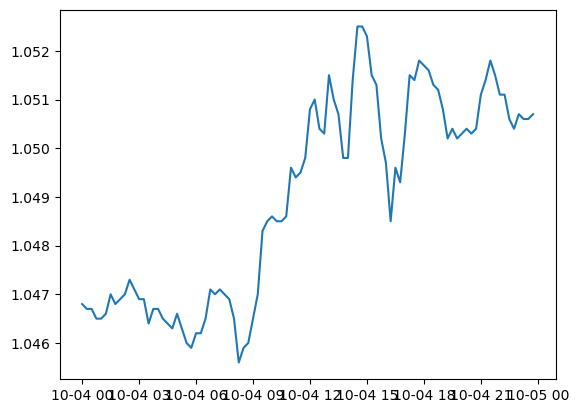

In [17]:
pyplot.plot(subset['Close'])
pyplot.show()

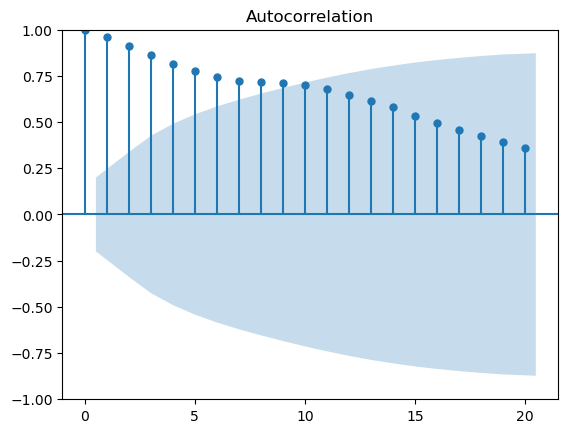

In [18]:
close_series = pd.Series(subset['Close'])
squared_data = close_series ** 2
# create acf plot
plot_acf(squared_data)
pyplot.show()

In [19]:
n_test = 10
train, test = subset[:-n_test], subset[-n_test:]
scaled_train = train * 1000
print(scaled_train['Close'].head())
scaled_train['Close']= pd.to_numeric(scaled_train['Close'])


Dates
2023-10-04 00:00:00    1046.8
2023-10-04 00:15:00    1046.7
2023-10-04 00:30:00    1046.7
2023-10-04 00:45:00    1046.5
2023-10-04 01:00:00    1046.5
Name: Close, dtype: object


## Models 

In [25]:
# Garch(2,1)
model_2_1 = arch_model(scaled_train['Close'], mean='Zero', vol='GARCH', p=2, q=1)
# fit model
model_fit_2_1 = model_2_1.fit()
# forecast the test set
yhat_2_1 = model_fit_2_1.forecast(horizon=n_test)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 720.3423508666951
Iteration:      2,   Func. Count:     13,   Neg. LLF: 720.1873537905542
Optimization terminated successfully    (Exit mode 0)
            Current function value: 720.1873537905528
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2


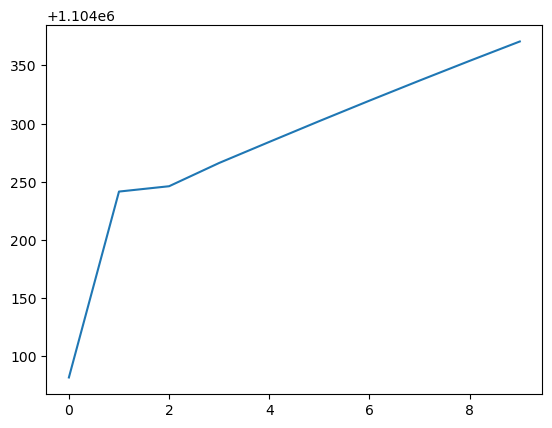

In [26]:
pyplot.plot(yhat_2_1.variance.values[-1, :])
pyplot.show()

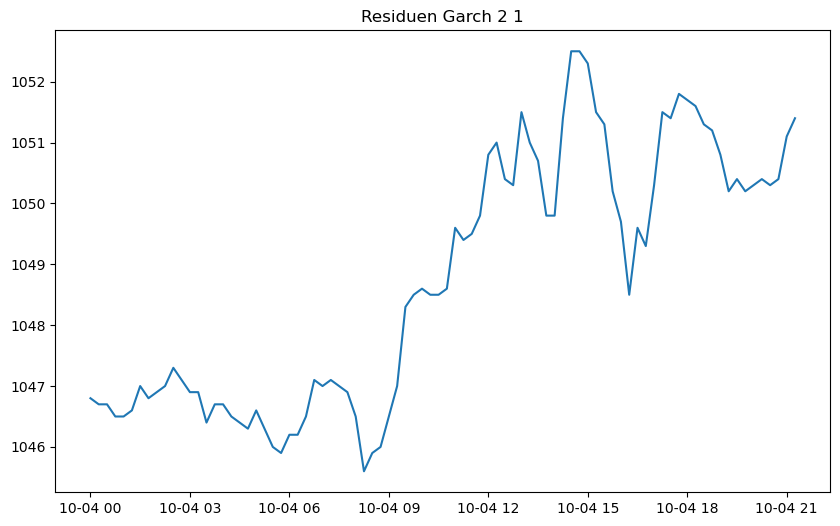

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(model_fit_2_1.resid)
plt.title('Residuen Garch 2 1')
plt.show()

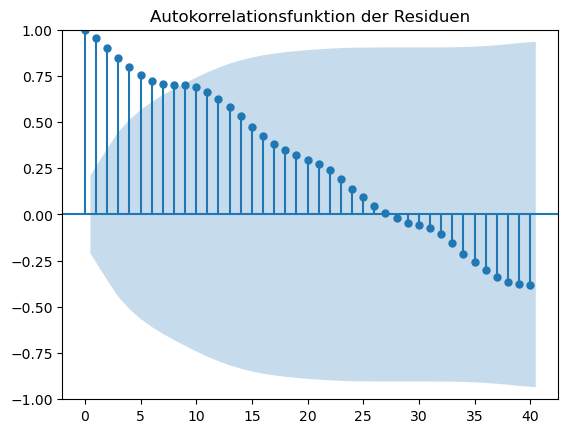

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# ACF-Plot der Residuen
plot_acf(model_fit_2_1.resid, lags=40)
plt.title('Autokorrelationsfunktion der Residuen')
plt.show()

### Garch 2 2

In [30]:
model_2_2 = arch_model(scaled_train['Close'], mean='Zero', vol='GARCH', p=2, q=2)
# fit model
model_fit_2_2 = model_2_2.fit()
# forecast the test set
yhat_2_2 = model_fit_2_2.forecast(horizon=n_test)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 720.3402913930513
Iteration:      2,   Func. Count:     15,   Neg. LLF: 720.1873594148902
Iteration:      3,   Func. Count:     20,   Neg. LLF: 720.1873594148916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 720.1873594148902
            Iterations: 3
            Function evaluations: 20
            Gradient evaluations: 3


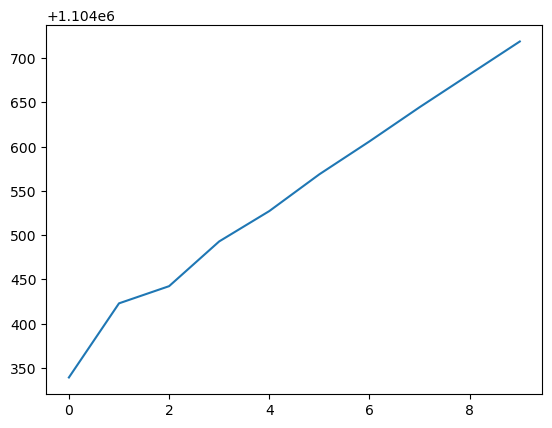

In [31]:
pyplot.plot(yhat_2_2.variance.values[-1, :])
pyplot.show()

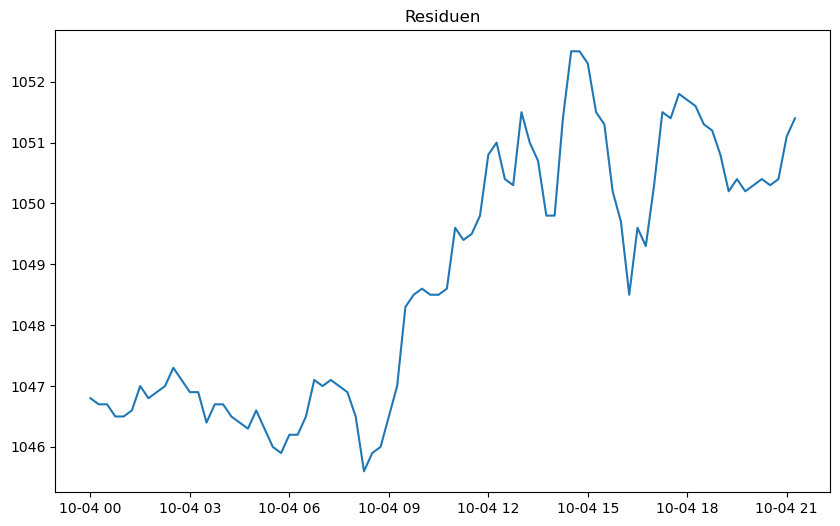

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(model_fit_2_2.resid)
plt.title('Residuen')
plt.show()

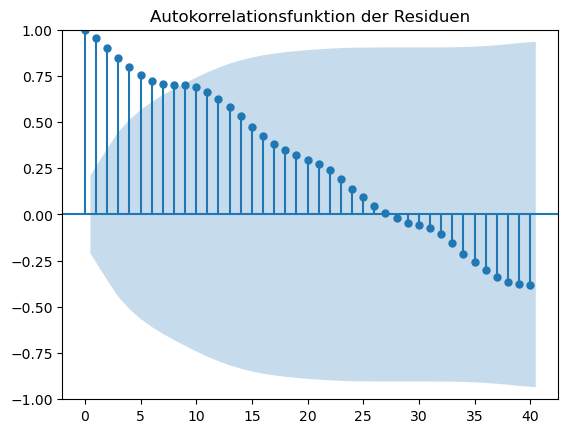

In [33]:
# ACF-Plot der Residuen
plot_acf(model_fit_2_2.resid, lags=40)
plt.title('Autokorrelationsfunktion der Residuen')
plt.show()

In [34]:
# Ljung-Box-Test
ljung_box_result = acorr_ljungbox(model_fit_2_2.resid, lags=[10], return_df=True)
print(ljung_box_result)

       lb_stat      lb_pvalue
10  571.716555  2.012879e-116


Der niedrige P-Wert und der hohe Ljung Box wert suggerieren, dass die abhängigkeit der Daten nicht gut erfasst werden kann. Schlussfolgerung = Modell ist kacke

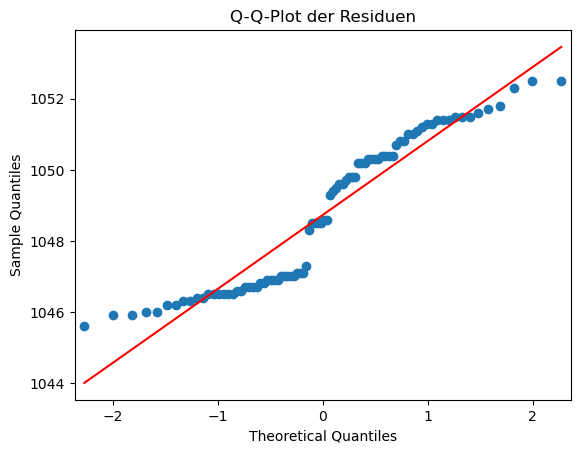

Jarque-Bera-Test: p-Wert = 0.015070819758401377


In [36]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import jarque_bera

# Q-Q-Plot der Residuen
qqplot(model_fit_2_2.resid, line='s')
plt.title('Q-Q-Plot der Residuen')
plt.show()

# Jarque-Bera-Test
jb_test_result = jarque_bera(model_fit_2_2.resid)
print('Jarque-Bera-Test: p-Wert =', jb_test_result[1])

## ARMA GARCH

### ARMA GARCH (2,1)

In [37]:
model_arma_garch = arch_model(scaled_train['Close'], mean='AR', lags=1, vol='Garch', p=2, q=1)
results_arma_garch = model_arma_garch.fit()
#print(results_arma_garch.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 88099476404776.97
Iteration:      2,   Func. Count:     24,   Neg. LLF: 267.2980844317942
Iteration:      3,   Func. Count:     35,   Neg. LLF: 62.813618469940145
Iteration:      4,   Func. Count:     43,   Neg. LLF: 57.75581121669791
Iteration:      5,   Func. Count:     51,   Neg. LLF: 61.00776829319272
Iteration:      6,   Func. Count:     59,   Neg. LLF: 57.055504966796704
Iteration:      7,   Func. Count:     67,   Neg. LLF: 56.228047077196386
Iteration:      8,   Func. Count:     75,   Neg. LLF: 56.468399280239915
Iteration:      9,   Func. Count:     83,   Neg. LLF: 55.99294028641901
Iteration:     10,   Func. Count:     90,   Neg. LLF: 56.0540069448527
Iteration:     11,   Func. Count:     98,   Neg. LLF: 55.98416058779986
Iteration:     12,   Func. Count:    105,   Neg. LLF: 55.97627167100111
Iteration:     13,   Func. Count:    112,   Neg. LLF: 55.92609604787551
Iteration:     14,   Func. Count:    119,   Neg. LLF: 55.6742

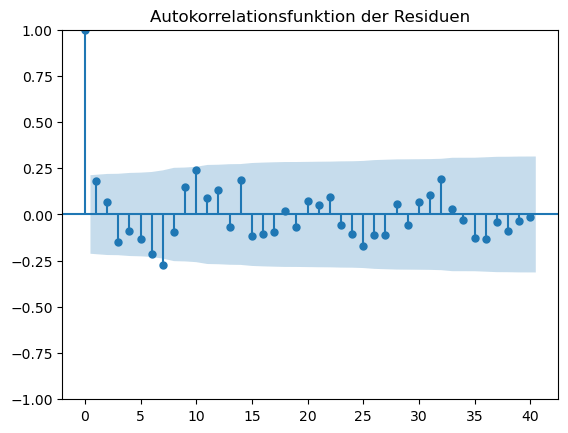

In [38]:
residuals = results_arma_garch.resid

# warum ist da ein NaN drin?
residuals_clean = residuals.dropna()

# ACF-Plot der Residuen
plot_acf(residuals_clean, lags=40)
plt.title('Autokorrelationsfunktion der Residuen')
plt.show()

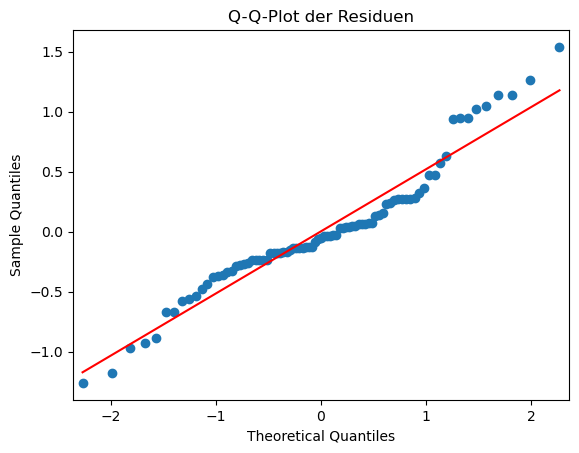

Jarque-Bera-Test: p-Wert = 0.027158951150045983


In [39]:
# Q-Q-Plot der Residuen
qqplot(residuals_clean, line='s')
plt.title('Q-Q-Plot der Residuen')
plt.show()

# Jarque-Bera-Test
jb_test_result = jarque_bera(residuals_clean)
print('Jarque-Bera-Test: p-Wert =', jb_test_result[1])

H0 dass die Residuen Normalverteilt sind kann bei signifikanz von 5% abgelehnt werden.